# Live trade list quick PnL

Fill the variables below, then run.

rows: 38
portfolio_return: -0.013931966449785293
return stats:
count    38.000000
mean     -0.013932
std       0.018249
min      -0.055231
25%      -0.019853
50%      -0.014541
75%      -0.008061
max       0.052852
Name: return, dtype: float64


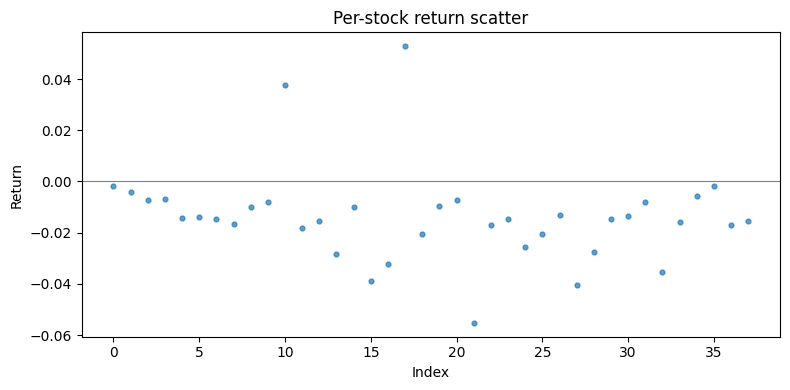

,code,weight,return
0,110070.SH,0.026316,-0.001838
1,110093.SH,0.026316,-0.004217
2,110097.SH,0.026316,-0.007222
3,111003.SH,0.026316,-0.006841
4,111010.SH,0.026316,-0.014291


In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
trade_day = '2026-01-13'  # trade_list date
signal_name = 'combo_default'
batch_id = 'Live'
results_root = Path('D:/cbond_daily/results')
cleaned_root = Path('D:/cbond_daily/clean_data')

buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'
twap_bps = 1.5
fee_bps = 0.7

# ---- load trade list ----
trade_dir = results_root / 'live' / trade_day / batch_id / signal_name
trade_path = trade_dir / 'trade_list.csv'
trades = pd.read_csv(trade_path)
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

# ---- load cleaned data for trade_day ----
day = pd.to_datetime(trade_day).date()
month = f'{day.year:04d}-{day.month:02d}'
cleaned_path = cleaned_root / month / f'{day:%Y%m%d}.parquet'
df = pd.read_parquet(cleaned_path)

# ---- merge and compute return ----
merged = trades.merge(df[['code', buy_twap_col, sell_twap_col]], on='code', how='left')

def apply_bps(px, bps, side):
    if side == 'buy':
        return px * (1 + bps / 10000.0)
    return px * (1 - bps / 10000.0)

cost_bps = twap_bps + fee_bps
buy_px = apply_bps(merged[buy_twap_col], cost_bps, 'buy')
sell_px = apply_bps(merged[sell_twap_col], cost_bps, 'sell')
merged['return'] = (sell_px - buy_px) / buy_px

# ---- summary ----
merged['weight'] = merged.get('weight', 1.0 / len(merged))
merged['weight'] = merged['weight'].fillna(0.0)
port_ret = float((merged['return'] * merged['weight']).sum())
print('rows:', len(merged))
print('portfolio_return:', port_ret)

# ---- per-stock stats ----
stats = merged['return'].describe()
print('return stats:')
print(stats)

# ---- scatter plot ----
plt.figure(figsize=(8, 4))
plt.scatter(range(len(merged)), merged['return'], s=12, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Per-stock return scatter')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()
merged[['code', 'weight', 'return']].head()


In [6]:
merged

,trade_date,code,weight,twap_0945_1000,twap_1430_1442,return
0,2026-01-13,110070.SH,0.026316,127.7288,127.5501,-0.001838
1,2026-01-13,110093.SH,0.026316,138.8355,138.3109,-0.004217
2,2026-01-13,110097.SH,0.026316,150.3039,149.2841,-0.007222
3,2026-01-13,111003.SH,0.026316,137.1028,136.2248,-0.006841
4,2026-01-13,111010.SH,0.026316,147.7400,145.6928,-0.014291
5,2026-01-13,111018.SH,0.026316,132.5060,130.7191,-0.013919
6,2026-01-13,111020.SH,0.026316,140.3414,138.3603,-0.014550
7,2026-01-13,113649.SH,0.026316,143.3109,141.0024,-0.016541
8,2026-01-13,113677.SH,0.026316,247.5839,245.2047,-0.010045
9,2026-01-13,113680.SH,0.026316,136.1910,135.1573,-0.008027
